The MIT License (MIT)

Copyright (c) 2023 Weizmann Institute of Science
Copyright (c) 2023 Elad Noor

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [4]:
from pathlib import Path
import seaborn as sns

import util
from path_finder import PathFinder
from cobra.io import read_sbml_model
from equilibrator_api import ComponentContribution, Q_
import matplotlib.pyplot as plt
from rpy2.rinterface_lib import callbacks
import logging
from rpy2.rinterface import RRuntimeWarning
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=RRuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
callbacks.logger.setLevel(logging.CRITICAL)

sns.set_style("whitegrid")

In [5]:
comp_contrib = ComponentContribution()

In [6]:
SCENARIOS = {
    "fix_co2": {"co2_c": -3, "pyr_c": 1}, # 3 CO2 -> pyruvate
    "fix_acetate": {"accoa_c": -2, "oaa_c": 1, "coa_c": 2}, # 2 acetyl-CoA → oxaloacetate + 2 CoA
    "fix_1_x_co2_and_1_x_acetate": {"accoa_c": -1, "co2_c": -1, "pyr_c": 1, "coa_c": 1}, # acetyl-CoA + CO2 → pyruvate
    "fix_2_x_co2_and_1_x_acetate": {"accoa_c": -1, "co2_c": -2, "oaa_c": 1, "coa_c": 1}, # acetyl-CoA + 2 CO2 → oxaloacetate + CoA
    "fix_2_x_co2_and_3_x_acetate": {"accoa_c": -3, "co2_c": -2, "oaa_c": 2, "coa_c": 3}, # 3 acetyl-CoA + 2 CO2 → 2 oxaloacetate + 3 CoA
}
CO2_CONCENTRATION_IN_MILLIMOLAR = None  # leave as None for the default (ambient) value of 5 micromolar

In [7]:
for title, pathway_objective in SCENARIOS.items():
    cobra_model = read_sbml_model("iML1515.xml.gz")
    conc_bounds = util.read_compound_bounds("concentration_bounds.csv", comp_contrib)
    
    if CO2_CONCENTRATION_IN_MILLIMOLAR is not None:
        conc_bounds.set_bounds(
            comp_contrib.get_compound("bigg.metabolite:co2"),
            lb=Q_(CO2_CONCENTRATION_IN_MILLIMOLAR, "mM"),
            ub=Q_(CO2_CONCENTRATION_IN_MILLIMOLAR, "mM")
        )

    print(f"***** Objective: {title} *****")
    path_finder = PathFinder.initialize_standard_ecoli_model(
        pathway_objective,
        conc_bounds=conc_bounds,
        cobra_model=cobra_model,
        comp_contrib=comp_contrib,
    )
    path_finder.result_dir = Path(f"res/{title}")
    path_finder.num_reactions_ub = 25  # upper bound on the number of reactions in each pathway
    path_finder.sum_of_fluxes_ub = 50.0  # upper bound on the sum of absolute fluxes
    path_finder.mdf_lb = Q_(0.0, "kJ/mol") # lower bound on the MDF
    path_finder.max_iterations = 20  # stop the search after reaching this number of pathways
    path_finder.search_radius = 2  # the exclusion radius around older solutions
    
    ## Stage 1: Search for pathways using Mixed-Integer Linear Programming (MILP)
    # Search for pathways using MILP and write them to the `pathways.tsv` file
    solutions = path_finder.search()
    
    if len(solutions) == 0:
        print("No solutions found")
        continue

    # Plot the pathways using GDot
    path_finder.write_solution_sbtabs(solutions)
    path_finder.draw_solution_graphs(solutions)


    ## Stage 2: Populate models with kinetics using ENKIE
    # Use ENKIE to find kinetic parameters and create configuration files for MDF/ECM
    path_finder.create_ecm_configuration_files()


    ## Stage 3: Run Max-min Driving Force (MDF) and Enzyme Cost Minimization (ECM) analyses
    # Run ECM on each pathway and collect the statistics (length, total_flux, MDF score, ECM score)
    path_finder.run_mdf()
    path_finder.run_ecm()
    
    # Plot the MDF versus ECM scores
    fig = path_finder.plot_pareto()
    plt.close(fig)

***** Objective: fix_co2 *****
Read LP format model from file /tmp/tmpfxp8d_9_.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21140 nonzeros


Running ENKIE on each pathway:   5%|██▋                                                  | 1/20 [01:15<23:46, 75.10s/it]WARNING:enkie.estimators.equilibrator_gibbs_estimator:The following metabolites could not be found in eQuilibrator:
    bigg.metabolite:nadhx__S
Running ENKIE on each pathway:  20%|██████████▌                                          | 4/20 [04:22<17:08, 64.31s/it]WARNING:enkie.io.cobra:Multiple EC numbers found: ['1.4.4.2', '2.1.2.10']. Using 1.4.4.2
    bigg.metabolite:micit
Running ENKIE on each pathway:  30%|███████████████▉                                     | 6/20 [06:25<14:40, 62.92s/it]WARNING:enkie.io.cobra:Multiple EC numbers found: ['1.4.4.2', '2.1.2.10']. Using 1.4.4.2
    bigg.metabolite:micit
Running ENKIE on each pathway:  45%|███████████████████████▊                             | 9/20 [09:34<11:44, 64.00s/it]WARNING:enkie.estimators.equilibrator_gibbs_estimator:The following metabolites could not be found in eQuilibrator:
    bigg.metabolite:nadphx__S

***** Objective: fix_acetate *****
Read LP format model from file /tmp/tmp489rgoco.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21136 nonzeros


Running ENKIE on each pathway:  20%|██████████▌                                          | 4/20 [03:24<14:00, 52.56s/it]WARNING:enkie.estimators.equilibrator_gibbs_estimator:The following metabolites could not be found in eQuilibrator:
    bigg.metabolite:hxcoa
Running MDF on each pathway:  20%|███████████                                            | 4/20 [00:02<00:09,  1.72it/s]/home/eladn/git/ged-cycle/path_finder.py:984: UserWarning: Reaction FACOAE60 is not balanced
  model = ThermodynamicModel.from_sbtab(
/home/eladn/git/ged-cycle/path_finder.py:984: UserWarning: Reaction HXCT is not balanced
  model = ThermodynamicModel.from_sbtab(
/home/eladn/git/ged-cycle/venv/lib/python3.11/site-packages/equilibrator_cache/reaction.py:606: UserWarning: Cannot calculate Legendre transform for Compound(id=132041, inchi_key=None): Compound(id=132041, inchi_key=None) has not yet been analyzed by ChemAxon.
  warnings.warn(
Running ECM on each pathway:  20%|███████████                               

***** Objective: fix_1_x_co2_and_1_x_acetate *****
Read LP format model from file /tmp/tmp6opjtm7_.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21134 nonzeros


Running ENKIE on each pathway:   0%|                                                             | 0/20 [00:00<?, ?it/s]WARNING:enkie.io.cobra:Multiple EC numbers found: ['1.4.4.2', '2.1.2.10']. Using 1.4.4.2
    bigg.metabolite:micit
Running ENKIE on each pathway:   5%|██▋                                                  | 1/20 [00:55<17:41, 55.85s/it]WARNING:enkie.io.cobra:Multiple EC numbers found: ['2.3.1.54', '2.3.1.-']. Using 2.3.1.54
    bigg.metabolite:micit
Running ENKIE on each pathway:  10%|█████▎                                               | 2/20 [01:55<17:24, 58.01s/it]WARNING:enkie.io.cobra:Multiple EC numbers found: ['2.3.1.54', '2.3.1.-']. Using 2.3.1.54
    bigg.metabolite:micit
Running ENKIE on each pathway:  15%|███████▉                                             | 3/20 [02:55<16:44, 59.11s/it]WARNING:enkie.io.cobra:EC numbers of reaction ADK3 don't match EC numbers of genes.
    bigg.metabolite:micit
Running ENKIE on each pathway:  20%|██████████▌                

***** Objective: fix_2_x_co2_and_1_x_acetate *****
Read LP format model from file /tmp/tmp2yxzjjn0.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21142 nonzeros


Running ENKIE on each pathway:   0%|                                                             | 0/20 [00:00<?, ?it/s]WARNING:enkie.io.cobra:Multiple EC numbers found: ['2.3.1.54', '2.3.1.-']. Using 2.3.1.54
    bigg.metabolite:micit
Running ENKIE on each pathway:   5%|██▋                                                  | 1/20 [00:49<15:49, 49.96s/it]WARNING:enkie.io.cobra:Multiple EC numbers found: ['1.4.4.2', '2.1.2.10']. Using 1.4.4.2
    bigg.metabolite:micit
Running ENKIE on each pathway:  10%|█████▎                                               | 2/20 [01:51<17:05, 56.95s/it]WARNING:enkie.io.cobra:Multiple EC numbers found: ['1.4.4.2', '2.1.2.10']. Using 1.4.4.2
    bigg.metabolite:micit
Running ENKIE on each pathway:  15%|███████▉                                             | 3/20 [02:47<15:59, 56.44s/it]WARNING:enkie.io.cobra:Multiple EC numbers found: ['1.4.4.2', '2.1.2.10']. Using 1.4.4.2
    bigg.metabolite:micit
Running ENKIE on each pathway:  20%|██████████▌            

***** Objective: fix_2_x_co2_and_3_x_acetate *****
Read LP format model from file /tmp/tmpt5qvka_o.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21136 nonzeros


Running ENKIE on each pathway:   0%|                                                             | 0/20 [00:00<?, ?it/s]WARNING:enkie.io.cobra:Multiple EC numbers found: ['1.4.4.2', '2.1.2.10']. Using 1.4.4.2
    bigg.metabolite:micit
Running ENKIE on each pathway:   5%|██▋                                                  | 1/20 [01:08<21:44, 68.65s/it]WARNING:enkie.io.cobra:Multiple EC numbers found: ['1.4.4.2', '2.1.2.10']. Using 1.4.4.2
    bigg.metabolite:micit
Running ENKIE on each pathway:  10%|█████▎                                               | 2/20 [02:16<20:32, 68.46s/it]WARNING:enkie.io.cobra:Multiple EC numbers found: ['1.4.4.2', '2.1.2.10']. Using 1.4.4.2
    bigg.metabolite:micit
Running ENKIE on each pathway:  15%|███████▉                                             | 3/20 [03:25<19:28, 68.71s/it]WARNING:enkie.io.cobra:Multiple EC numbers found: ['1.4.4.2', '2.1.2.10']. Using 1.4.4.2
    bigg.metabolite:micit
Running ENKIE on each pathway:  20%|██████████▌             

## Collect all pathways from all objective and plot their scores against each other

In [8]:
# collect all results in one summary table
result_dir = Path("res")

summary_df_list = []
for title, pathway_objective in SCENARIOS.items():
    summary_path = result_dir / title / "pathway_summary.csv"
    if summary_path.exists():
        summary_df = pd.read_csv(summary_path, index_col=0)
        summary_df.insert(0, column="objective", value=title)
        summary_df_list.append(summary_df)
summary_df = pd.concat(summary_df_list)

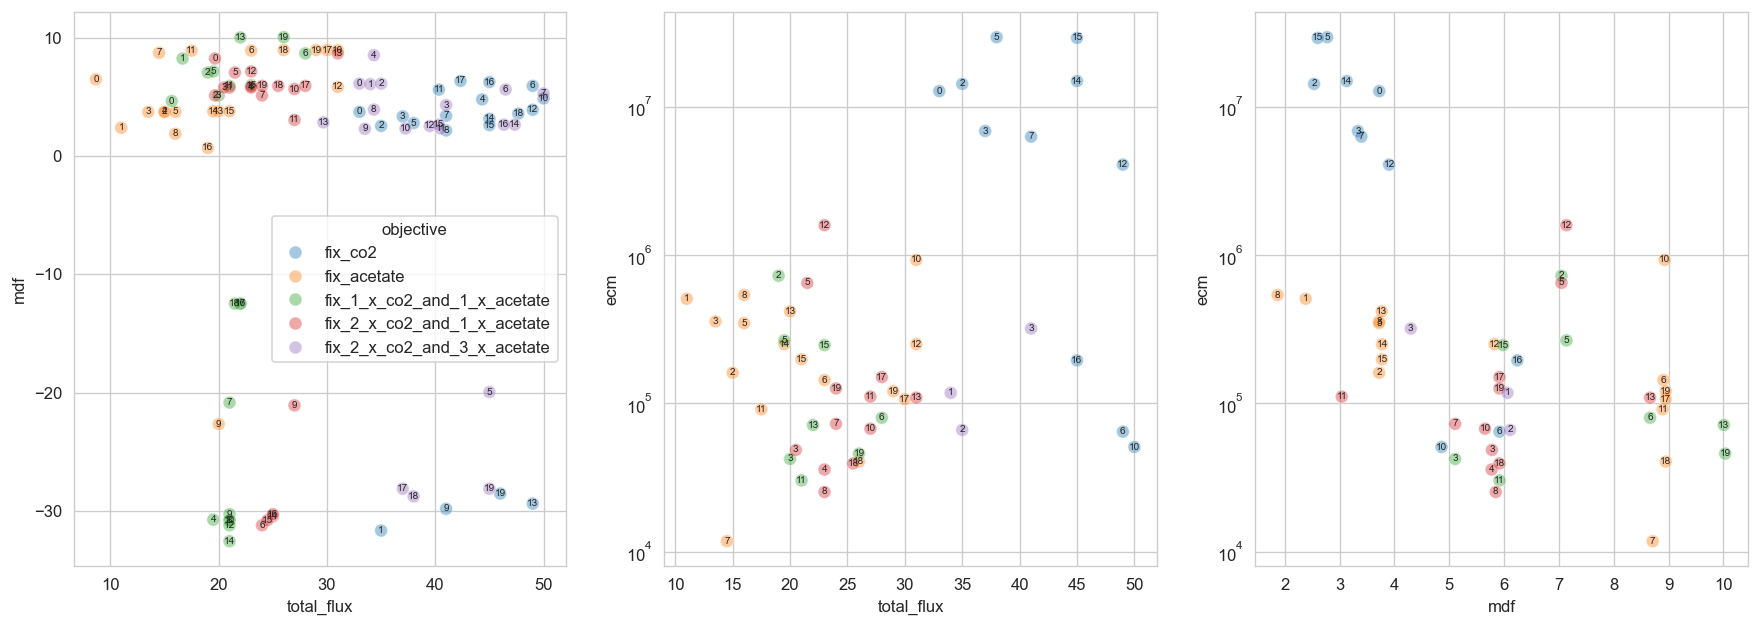

In [14]:
def scatter_plot_results(data: pd.DataFrame, x: str, y: str, legend: bool, ax: plt.Axes) -> None:
    if x == "ecm":
        ax.set_xscale("log")
        df = data[~pd.isnull(data.ecm)]
    elif y == "ecm":
        ax.set_yscale("log")
        df = data[~pd.isnull(data.ecm)]
    else:
        df = data
    sns.scatterplot(data=df, x=x, y=y, hue="objective", s=60, alpha=0.4, ax=ax, legend=legend)
    
    for idx, row in df.iterrows():
        if pd.isnull(row[x]) or pd.isnull(row[y]):
            continue
        ax.text(row[x], row[y], str(idx), ha="center", va="center", zorder=2, fontsize=6)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=120)

ax = axs[0]
scatter_plot_results(data=summary_df, x="total_flux", y="mdf", ax=ax, legend=True)

ax = axs[1]
scatter_plot_results(data=summary_df, x="total_flux", y="ecm", ax=ax, legend=False)

ax = axs[2]
scatter_plot_results(data=summary_df, x="mdf", y="ecm", ax=ax, legend=False)

fig.savefig("res/scatter_plot_summary.pdf")

In [10]:
summary_df

objective pathway_name  \
0                       fix_co2  pathway_000   
1                       fix_co2  pathway_001   
2                       fix_co2  pathway_002   
3                       fix_co2  pathway_003   
4                       fix_co2  pathway_004   
..                          ...          ...   
15  fix_2_x_co2_and_3_x_acetate  pathway_015   
16  fix_2_x_co2_and_3_x_acetate  pathway_016   
17  fix_2_x_co2_and_3_x_acetate  pathway_017   
18  fix_2_x_co2_and_3_x_acetate  pathway_018   
19  fix_2_x_co2_and_3_x_acetate  pathway_019   

                                        pathway_sbtab  n_reactions  \
0                 res/fix_co2/pathway/pathway_000.csv           17   
1                 res/fix_co2/pathway/pathway_001.csv           18   
2                 res/fix_co2/pathway/pathway_002.csv           18   
3                 res/fix_co2/pathway/pathway_003.csv           19   
4                 res/fix_co2/pathway/pathway_004.csv           20   
..                                                ...          ...   
15  res/fix_2_x_co2_and_3_x_acetate/pathway/pathwa...           25   
16  res/fix_2_x_co2_and_3_x_acetate/pathway/pathwa...           25   
17  res/fix_2_x_co2_and_3_x_acetate/pathway/pathwa...           25   
18  res/fix_2_x_co2_and_3_x_acetate/pathway/pathwa...           25   
19  res/fix_2_x_co2_and_3_x_acetate/pathway/pathwa...           25   

    total_flux                                   ecm_config_sbtab        mdf  \
0       33.000                res/fix_co2/ecm/pathway_000_ecm.tsv   3.724663   
1       35.000                res/fix_co2/ecm/pathway_001_ecm.tsv -31.662546   
2       35.000                res/fix_co2/ecm/pathway_002_ecm.tsv   2.536235   
3       37.000                res/fix_co2/ecm/pathway_003_ecm.tsv   3.336501   
4       44.334                res/fix_co2/ecm/pathway_004_ecm.tsv   4.774441   
..         ...                                                ...        ...   
15      40.334  res/fix_2_x_co2_and_3_x_acetate/ecm/pathway_01...   2.640598   
16      46.334  res/fix_2_x_co2_and_3_x_acetate/ecm/pathway_01...   2.640598   
17      37.000  res/fix_2_x_co2_and_3_x_acetate/ecm/pathway_01... -28.128088   
18      38.000  res/fix_2_x_co2_and_3_x_acetate/ecm/pathway_01... -28.768933   
19      45.000  res/fix_2_x_co2_and_3_x_acetate/ecm/pathway_01... -28.128088   

                                     mdf_result_sbtab           ecm  \
0         res/fix_co2/ecm/pathway_000_mdf_results.tsv  1.276871e+07   
1         res/fix_co2/ecm/pathway_001_mdf_results.tsv           NaN   
2         res/fix_co2/ecm/pathway_002_mdf_results.tsv  1.427486e+07   
3         res/fix_co2/ecm/pathway_003_mdf_results.tsv  6.871674e+06   
4         res/fix_co2/ecm/pathway_004_mdf_results.tsv           NaN   
..                                                ...           ...   
15  res/fix_2_x_co2_and_3_x_acetate/ecm/pathway_01...           NaN   
16  res/fix_2_x_co2_and_3_x_acetate/ecm/pathway_01...           NaN   
17  res/fix_2_x_co2_and_3_x_acetate/ecm/pathway_01...           NaN   
18  res/fix_2_x_co2_and_3_x_acetate/ecm/pathway_01...           NaN   
19  res/fix_2_x_co2_and_3_x_acetate/ecm/pathway_01...           NaN   

                               ecm_result_sbtab ecm_error_message  
0   res/fix_co2/ecm/pathway_000_ecm_results.tsv               NaN  
1                                           NaN        infeasible  
2   res/fix_co2/ecm/pathway_002_ecm_results.tsv               NaN  
3   res/fix_co2/ecm/pathway_003_ecm_results.tsv               NaN  
4                                           NaN        infeasible  
..                                          ...               ...  
15                                          NaN        infeasible  
16                                          NaN        infeasible  
17                                          NaN        infeasible  
18                                          NaN        infeasible  
19                                        